### Test application

![FittsLaw](fitts_law_test_application.png)

Mouse and touchpad input were tested on full hd screens with 24" and 14".

In [1]:
files = ['clicks_2020-01-24 09:48:51_touchpad_14"_monitor.csv',
         'clicks_2020-01-24 09:44:46_mouse_24"_monitor.csv',
         'clicks_2020-01-23 16:00:32_mouse_24"_monitor.csv']

Test data from the application loaded into a simple data container. One row contains the data of a click. If not changed the first file from `files` is loaded.


| circle_x | circle_y | click_x | click_y | timestamp                 | radius |
|----------|----------|---------|---------|---------------------------|--------|
| 391      | 207      | 426     | 232     | 2020-01-23 15:59:09.367584| 30     |

In [2]:
import csv
import numpy as np
import pandas as pd
from dataclasses import dataclass
from datetime import datetime, timedelta

In [3]:
@dataclass
class CircleClick():
    circle_x: int
    circle_y: int
    click_x: int
    click_y: int
    radius: int
    timestamp: datetime

In [4]:
clicks = []
with open(files[0]) as src:
    reader = csv.reader(src)
    for row in reader:
        circle_click = CircleClick(circle_x=int(row[0]), circle_y=int(row[1]), 
                                   click_x=int(row[2]), click_y=int(row[3]),
                                   timestamp=datetime.strptime(row[4], '%Y-%m-%d %H:%M:%S.%f'),
                                   radius=int(row[5]))
        clicks.append(circle_click)

In [5]:
clicks[0]

CircleClick(circle_x=164, circle_y=95, click_x=214, click_y=161, radius=50, timestamp=datetime.datetime(2020, 1, 24, 9, 46, 57, 626993))

*ID* is the index of difficulty.

$ID = \log_2 \left(\dfrac{2D}{W}\right)$

---

*D* is the distance from the starting point to the center of the target.

---

*W* is the width of the target measured along the axis of motion. W can also be thought of as the allowed error tolerance in the final position, since the final point of the motion must fall within $\pm \frac{W}{2}$ of the target's center.

---

*MT* is the average time to complete the movement.

a and b are constants that depend on the choice of input device and are usually determined empirically by regression analysis. a defines the intersection on the y-axis and is often as interpreted as a delay. The b-parameter is a slope and describes an acceleration. Both paramters show the linear dependency in Fitts' Law.

$MT = a + b \cdot ID = a + b \cdot \log_2 \left(\dfrac{2D}{W}\right) $

In [19]:
def distance(x1: int, x2: int, y1: int, y2: int):
    a = np.power(x1 - x2, 2)
    b = np.power(y1 - y2, 2)
    distance = np.sqrt(a + b)
    return distance

distance(0, 1, 0, 1)

1.4142135623730951

In [20]:
@dataclass 
class FittsModel:
    
    D: float = 0
    W: float = 0
    ID: float = 0
    MT: timedelta = timedelta(0)
        
    def calculate(self, start: CircleClick, end: CircleClick):
        """The model calculates its values D, W, ID and MT
        based on two clicks"""
        self.D = distance(start.click_x, 
                          end.circle_x + end.radius,
                          start.click_y,
                          end.circle_y + end.radius)
        self.W = end.radius * 2
        self.ID = np.log2(2 * self.D / self.W)
        self.MT = end.timestamp - start.timestamp
    
    @property
    def MT_in_millis(self):
        millis, micros = divmod(self.MT.microseconds, 1000)
        return self.MT.total_seconds() * 1000 + millis + micros / 1000

Calculate all models that can be drawn on the graph later on.

In [22]:
models = []
for i in range(1, len(clicks)):
    model = FittsModel()
    model.calculate(clicks[i - 1], clicks[i])
    models.append(model)
    
models[0]

FittsModel(D=442.52570546805526, W=20, ID=5.467689355900316, MT=datetime.timedelta(seconds=1, microseconds=54753))

All data is put into a pandas dataframe for easier selection and matplot drawing

In [9]:
data = {'D': [], 'W': [], 'ID': [], 'MT': []}
for m in models:
    data['D'].append(m.D)
    data['W'].append(m.W)
    data['ID'].append(m.ID)
    data['MT'].append(m.MT_in_millis)
df = pd.DataFrame(data=data)
df

,D,W,ID,MT
0,442.525705,20,5.467689,1109.506
1,457.787068,60,3.931642,1273.220
2,899.093988,100,4.168472,1684.354
3,1449.593736,60,5.594542,1582.688
4,1355.389981,20,7.082564,2196.954
...,...,...,...,...
84,458.132077,100,3.195764,1538.216
85,389.790970,60,3.699666,1359.228
86,1154.291124,60,5.265901,1851.240
87,626.247555,100,3.646733,1688.028


In [10]:
widths = set([m.W for m in models])
widths

{20, 60, 100}

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

In [12]:
matplotlib.rcParams['figure.figsize']

[6.0, 4.0]

In [13]:
matplotlib.rcParams['figure.figsize'] = [12, 8]

In [14]:
df['ID'].mean()

4.816399691624198

In [15]:
df.groupby(['W']).mean()

,D,ID,MT
W,,,
20,843.127578,6.215251,1964.482200
60,798.822448,4.592873,1462.410733
100,723.879028,3.600547,1600.858483


In [16]:
df.groupby(['W']).median()

,D,ID,MT
W,,,
20,669.599816,6.065225,2008.876
60,725.415676,4.593681,1379.169
100,670.663105,3.745588,1641.324


In [17]:
from sklearn.linear_model import LinearRegression

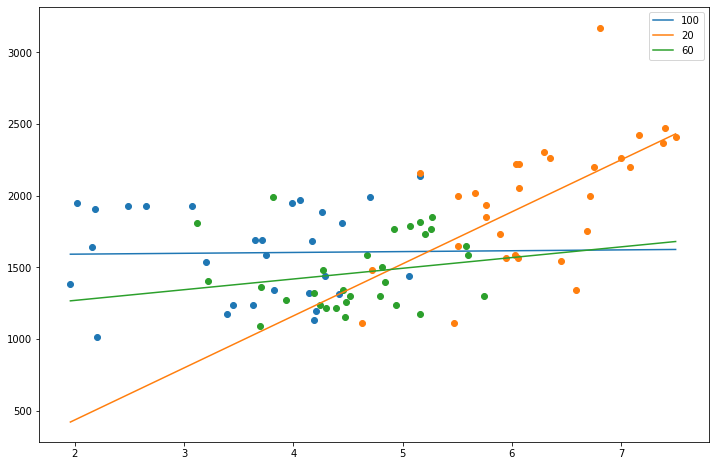

In [18]:
for width in widths:
    
    _df = df[df['W'] == width]
    
    model = LinearRegression()
    model.fit(_df[['ID']], _df[['MT']])
    
    min_x = min(df['ID'])
    max_x = max(df['ID'])
    predicted = model.predict([[min_x], [max_x]])
    
    plt.scatter(x=_df['ID'], y=_df['MT'])
    plt.plot([min_x, max_x], predicted)
    
plt.legend(widths)
plt.show()